In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", message="Adding an axes using the same arguments")
from scipy.stats import lomax
from collections import Counter
from scipy.stats import gamma
from scipy.stats import beta

In [3]:
%run -i MABs_KL_Functions
%run -i MABs_Env_Generations
%run -i MABs_MPs_Classes_Functions
%run -i MABs_MPs_Exp_Generations

In [132]:
class player_m:
    def __init__(self, n_arms, player_index, n_players, n_rounds):
        self.regrets = []
        self.cumulative_regret = 0
        self.cumulative_regrets = []
        self.means = np.zeros(shape = n_arms)
        self.n_trials = np.zeros(shape = n_arms)
        self.choices = []
        self.all_rewards = np.zeros(shape = (n_arms, n_players, n_rounds))
        self.all_trials = np.zeros(shape = (n_arms, n_players, n_rounds))
        self.n_arms = n_arms
        self.player_index = player_index
        self.n_players = n_players
            
    def update_n_trials(self, choice, current_round):
        if choice != None:
            self.all_trials[choice, self.player_index, current_round] = 1
            self.n_trials[choice] += 1
               
    def receive_n_trials(self, other_trials, index = None):
        if index is None:
            self.all_trials[(self.all_trials == 0) & (other_trials == 1)] = 1
            self.n_trials = self.all_trials.sum(axis = 2).sum(axis =  1)
        else:
            self.all_trials[(self.all_trials == 0) & (other_trials == 1)] = 1
            self.n_trials[index] = self.all_trials.sum(axis = 2).sum(axis =  1)[index]
                
    def receive_reward(self, other_reward, index = None, single = False):
        if single is True:
            if index is None:
                self.all_rewards[(self.all_rewards == 0) & (other_reward != 0)] = other_reward[(self.all_rewards == 0) & (other_reward != 0)]
                self.means = self.all_rewards.sum(axis = 2).sum(axis = 1)/self.n_players*self.n_trials
            else:
                self.all_rewards[(self.all_rewards == 0) & (other_reward != 0)] = other_reward[(self.all_rewards == 0) & (other_reward != 0)]
                self.means[index] = self.all_rewards.sum(axis = 2).sum(axis = 1)[index]/self.n_players*self.n_trials[index]
        else:
            if index is None:
                self.all_rewards[(self.all_rewards == 0) & (other_reward != 0)] = other_reward[(self.all_rewards == 0) & (other_reward != 0)]
                self.means = self.all_rewards.sum(axis = 2).sum(axis = 1)/self.n_trials
            else:
                self.all_rewards[(self.all_rewards == 0) & (other_reward != 0)] = other_reward[(self.all_rewards == 0) & (other_reward != 0)]
                self.means[index] = self.all_rewards.sum(axis = 2).sum(axis = 1)[index]/self.n_trials[index]
                
    def update_mean(self, choice, reward, current_round):
        if choice != None:
            self.all_rewards[choice, self.player_index, current_round] = reward
            increment = (reward - self.means[choice])/self.n_trials[choice]
            self.means[choice] += increment
        
    def update_regret(self, reward, best_reward):
        regret = best_reward - reward
        self.regrets.append(regret)
        self.cumulative_regret += regret
        self.cumulative_regrets.append(self.cumulative_regret)

In [147]:
def multiple_experiment(n_arms, n_players, n_rounds, n_iterations, com_freqs, title, player_type, lambdas = None, beta = 1, conc = 0.5, dist = 'Dirichlet', temp = None, n_variables = None, scale = 1, shape = 1, d = None, info = 'all', single = False):
    if dist == 'Dirichlet':
        env = env_generation(n_arms = n_arms, n_variables = n_variables, conc = conc)
        ranked_means = sorted(env.all_means)
        if player_type == 'thom':
            lb = 1
            ub = n_variables
    elif dist == 'Bernoulli':
        env = env_generation(n_arms = n_arms, n_variables = n_variables, dist = dist)
        ranked_means = sorted(env.all_means)
        if player_type == 'thom':
            lb = 0
            ub = 1
        
    if player_type == 'thom':
        if dist == 'Exponential':
            ub = np.random.exponential(scale = np.max(lambdas), size = 1000).max()
            lb = np.random.exponential(scale = np.min(lambdas), size = 1000).min()
        elif dist == 'Poisson':
            ub = np.random.poisson(lam = np.max(lambdas), size = 1000).max()
            lb = np.random.poisson(lam = np.min(lambdas), size = 1000).min()
        elif dist == 'Dirichlet':
            ub = 10
            lb = 1
       
    trials = pd.DataFrame()
    for f in tqdm(range(len(com_freqs))):
        com_freq = com_freqs[f]
        all_regrets = np.zeros(shape = (n_iterations, n_rounds, n_players))
        all_choices = np.zeros(shape = (n_iterations, n_rounds, n_players))
        
        for j in range(n_iterations):
            choices_rank = np.zeros(shape = (n_rounds, n_players))
            all_players = []
            for i in range(n_players):
                if player_type == 'ucb1':
                    player = ucb_1_player(n_arms = n_arms, beta = beta, player_index = i, n_players = n_players, n_rounds = n_rounds)
                elif player_type == 'ucbv':
                    player = ucb_v_player(n_arms = n_arms, beta = beta, player_index = i, n_players = n_players, n_rounds = n_rounds)
                elif player_type == 'moss':
                    player = ucb_moss_player(n_arms = n_arms, player_index = i, n_players = n_players, n_rounds = n_rounds, beta = beta)
                elif player_type == 'ucbkl':
                    player = ucb_kl_player(n_arms = n_arms, player_index = i, n_players = n_players, n_rounds = n_rounds, dist = dist)
                elif player_type == 'soft-eps':
                    player = soft_eps_player(n_arms = n_arms, player_index = i, n_players = n_players, n_rounds = n_rounds, temp = temp)
                elif player_type == 'bayes':
                    player = bayes_player(n_arms = n_arms, player_index = i, n_players = n_players, n_rounds = n_rounds, dist = dist, scale = scale, shape = shape)
                elif player_type == 'thom':
                    player = thom_player(n_arms = n_arms, player_index = i, n_players = n_players, n_rounds = n_rounds, dist = dist, lb = lb, ub = ub)
                elif player_type == 'eps':
                    player = eps_player(n_arms = n_arms, player_index = i, n_players = n_players, n_rounds = n_rounds, prob = decay_prob(d))
                all_players.append(player)
            counter = 0
            for i in range(1, n_rounds + 1):
                choices = [None for i in range(n_players)]
                rewards = np.zeros(shape = n_players)
                if i <= all_players[0].n_arms:
                    choices = [i-1 for j in range(n_players)]
                    for n in range(n_players):
                        all_players[n].choices.append(choices[n])
                else:
                    for n in range(n_players):
                        if i in com_freq:
                            all_players[n].choices.append(None)
                            for m in range(n_players):
                                if j != m:
                                    if single is False:
                                        if info == 'all':
                                            all_players[n].receive_n_trials(all_players[m].all_trials)
                                            all_players[n].receive_reward(all_players[m].all_rewards)
                                        elif info == 'best':
                                            all_players[n].receive_n_trials(all_players[m].all_trials, np.argmax(all_players[m].means))
                                            all_players[n].receive_reward(all_players[m].all_rewards, np.argmax(all_players[m].means))
                                        elif info == 'random':
                                            index = np.random.choice(np.arange(n_arms))
                                            all_players[n].receive_n_trials(all_players[m].all_trials, index)
                                            all_players[n].receive_reward(all_players[m].all_rewards, index)
                                        elif info == 'second_best':
                                            means = list(all_players[n].means)
                                            index = means.index(sorted(means)[-2])
                                            all_players[n].receive_n_trials(all_players[m].all_trials, index)
                                            all_players[n].receive_reward(all_players[m].all_rewards, index)
                                        elif info == 'sub-optimal':
                                            while True:
                                                index = np.random.choice(np.arange(n_arms))
                                                if index != np.argmax(all_players[m].means):
                                                    break
                                            all_players[n].receive_n_trials(all_players[m].all_trials, index)
                                            all_players[n].receive_reward(all_players[m].all_rewards, index)
                                        elif type(info) == int or type(info) == float:
                                            if info == np.argmax(all_players[n].means):
                                                while True:
                                                    info = np.random.choice(np.arange(n_arms))
                                                    if info != np.argmax(all_players[n].means):
                                                        break
                                            all_players[n].receive_n_trials(all_players[m].all_trials, index = info)
                                            all_players[n].receive_reward(all_players[m].all_rewards, index = info)
                                        
                                    else:
                                        if info == 'all':
                                            all_players[n].receive_reward(all_players[m].all_rewards, single = single)
                                        elif info == 'best':
                                            all_players[n].receive_reward(all_players[m].all_rewards, np.argmax(all_players[m].means), single = single)
                                        elif info == 'random':
                                            index = np.random.choice(np.arange(n_arms))
                                            all_players[n].receive_reward(all_players[m].all_rewards, index, single = single)
                                        elif info == 'second_best':
                                            means = list(all_players[n].means)
                                            index = means.index(sorted(means)[-2])
                                            all_players[n].receive_reward(all_players[m].all_rewards, index, single = single)
                                        elif info == 'sub-optimal':
                                            while True:
                                                index = np.random.choice(np.arange(n_arms))
                                                if index != np.argmax(all_players[m].means):
                                                    break
                                            all_players[n].receive_reward(all_players[m].all_rewards, index, single = single)
                                        elif type(info) == int or type(info) == float:
                                            if info == np.argmax(all_players[n].means):
                                                while True:
                                                    info = np.random.choice(np.arange(n_arms))
                                                    if info != np.argmax(all_players[n].means):
                                                        break
                                            all_players[n].receive_reward(all_players[m].all_rewards, index = info, single = single)
                                        
                                    
                        else:
                            if player_type == 'ucbkl':
                                all_players[n].compute_ucbs(i, l_rate = 0.01, max_iter = 100000)
                            elif player_type in ['ucb1', 'ucbv', 'moss', 'bayes']:
                                all_players[n].compute_ucbs(i)
                            elif player_type == 'soft-eps' or player_type == 'eps':
                                exp = all_players[n].exp_vs_exp(i)
                                
                            if player_type == 'soft-eps' or player_type == 'eps':
                                choices[n] = all_players[n].choice(exp)
                            else:
                                choices[n] = all_players[n].choice()
                                
                if dist == 'Dirichlet' or dist == 'Bernoulli':
                    for p in range(len(choices)):
                        if choices[p] != None:
                            choices_rank[i-1, p] = ranked_means.index(env.all_means[choices[p]])
                        else:
                            choices_rank[i-1, p] = None
                                                                      
                for k in range(n_players):
                    if choices[k] != None:
                        if dist == 'Dirichlet' or dist == 'Bernoulli':
                            rewards[k] = np.random.choice(env.rewards, p = env.probs_matrix[choices[k], :])
                            best_reward = np.random.choice(env.rewards, p = env.probs_matrix[env.best_arm, :])
                        elif dist == 'Poisson':
                            rewards[k] = np.random.poisson(lam = lambdas[choices[k]])
                            best_reward = np.random.poisson(lam = lambdas[np.argmax(lambdas)])
                        elif dist == 'Exponential':
                            rewards[k] = np.random.exponential(scale = lambdas[choices[k]])
                            best_reward = np.random.exponential(scale = lambdas[np.argmax(lambdas)])

                for h in range(n_players):
                    all_players[h].update_n_trials(choices[h], i-1)
                    all_players[h].update_mean(choices[h], rewards[h], i-1)
                    if player_type == 'ucbv':
                        all_players[h].update_variance(choices[h])
                    if player_type == 'bayes':
                        all_players[h].update_params(choices[h], rewards[h])
                    if player_type == 'thom':
                        if dist != 'Bernoulli':
                            norm_reward = all_players[h].normalize(rewards[h])
                            all_players[h].update_params(choices[h], norm_reward)
                        else:
                            all_players[h].update_params(choices[h], rewards[h])
                    all_players[h].update_regret(rewards[h], best_reward)

            for l in range(n_players):
                all_regrets[j, :, l] = all_players[l].cumulative_regrets
                if dist == 'Bernoulli' or dist == 'Dirichlet':
                    all_choices[j, : , l] = choices_rank[:, l]
                else:
                    all_choices[j, : , l] = all_players[l].choices

        for i in range(n_players):
            trials[f'p{i+1}_{com_freq[0]}_regrets'] = all_regrets[:, :, i].mean(axis = 0)
            trials[f'p{i+1}_{com_freq[0]}_choices'] = all_choices[:, :, i].mean(axis = 0)
            trials[f'p{i+1}_{com_freq[0]}_stds'] = all_regrets[:, :, i].std(axis = 0)

    trials.to_csv(f'{n_players}_{title}.csv')

# UCB-1

In [134]:
class ucb_1_player(player_m):
    def __init__(self, n_arms, beta, player_index, n_players, n_rounds):
        super().__init__(n_arms, player_index, n_players, n_rounds)
        self.ucbs = np.zeros(shape = n_arms)
        self.beta = beta
        
    def compute_ucbs(self, current_round):
        self.ucbs[self.n_trials > 0] = np.sqrt(2*(self.beta**2)*np.log(current_round)/self.n_trials[self.n_trials > 0])
        
    def choice(self):
        choice = np.argmax(self.means + self.ucbs)
        self.choices.append(choice)
        return choice

## Geometric Grid

In [103]:
n_rounds = 20000
all_nums = [2,3,4]
com_freqs = [[750 for i in range(n_rounds)]]
for n in all_nums:
    exps = []
    for i in range(1, n_rounds):
        if n**i > n_rounds:
            break
        else:
            exps.append(n**i)
    com_freqs.append(exps)

n_arms = 10
beta = 2
n_variables = 10
conc = 10
n_rounds = 20000
n_players = 2
n_iterations = 100
dist = 'Dirichlet'
title = 'UCB1_Dirichlet_Uniform_Geom'

multiple_ucb_1(n_arms = n_arms, n_variables = n_variables, n_players = n_players, n_rounds = n_rounds, n_iterations = n_iterations, com_freqs = com_freqs, title = title, beta = beta, conc = conc, dist = dist)

100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [2:28:38<00:00, 1783.64s/it]


In [12]:
n_rounds = 20000
all_nums = [2,3,4,5]
com_freqs = [[1000 for i in range(n_rounds)]]
for n in all_nums:
    exps = []
    for i in range(1, n_rounds):
        if n**i > n_rounds:
            break
        else:
            exps.append(n**i)
    com_freqs.append(exps)

n_arms = 10
beta = 2
n_variables = 10
conc = 0.5
n_rounds = 20000
n_players = 2
n_iterations = 50
dist = 'Dirichlet'
title = 'UCB1_Dirichlet_Base_Geom'

multiple_ucb_1(n_arms = n_arms, n_variables = n_variables, n_players = n_players, n_rounds = n_rounds, n_iterations = n_iterations, com_freqs = com_freqs, title = title, beta = beta, conc = conc, dist = dist)

100%|█████████████████████████████████████████████████████████████████████████████████| 5/5 [1:18:44<00:00, 944.82s/it]


In [13]:
n_rounds = 20000
all_nums = [2,3,4,5]
com_freqs = [[1000 for i in range(n_rounds)]]
for n in all_nums:
    exps = []
    for i in range(1, n_rounds):
        if n**i > n_rounds:
            break
        else:
            exps.append(n**i)
    com_freqs.append(exps)

n_arms = 10
beta = 2
n_variables = 10
conc = 0.5
n_rounds = 20000
n_players = 2
n_iterations = 50
dist = 'Dirichlet'
title = 'UCB1_Dirichlet_Degenerate_Geom'

multiple_ucb_1(n_arms = n_arms, n_variables = n_variables, n_players = n_players, n_rounds = n_rounds, n_iterations = n_iterations, com_freqs = com_freqs, title = title, beta = beta, conc = conc, dist = dist)

100%|█████████████████████████████████████████████████████████████████████████████████| 5/5 [1:20:38<00:00, 967.75s/it]


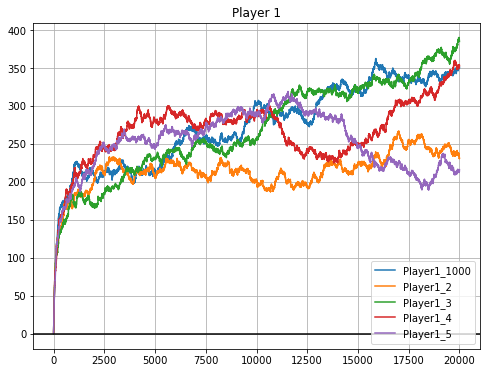

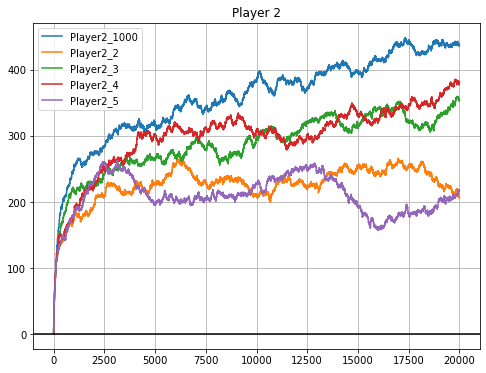

In [14]:
data = pd.read_csv('2_UCB1_Dirichlet_Base_Geom.csv').drop('Unnamed: 0', axis = 1)
two_regrets(data)

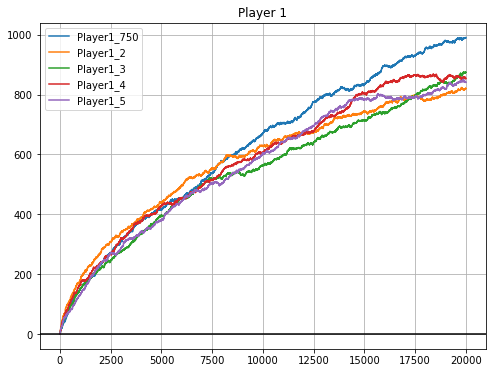

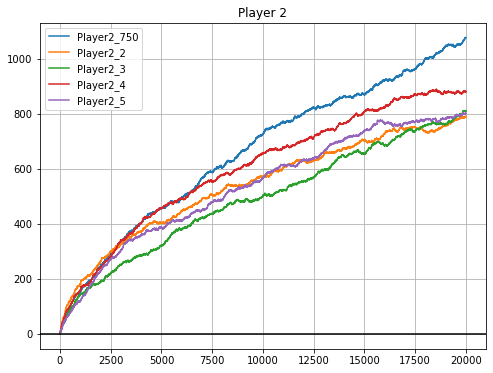

In [104]:
data = pd.read_csv('2_UCB1_Dirichlet_Uniform_Geom.csv').drop('Unnamed: 0', axis = 1)
two_regrets(data)

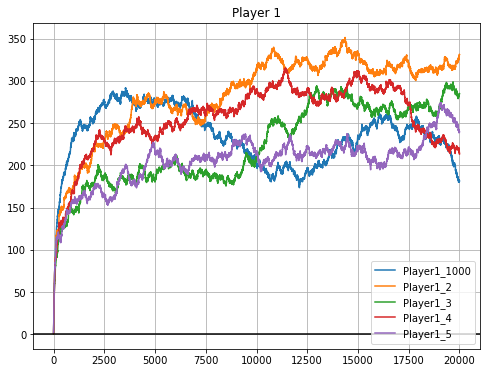

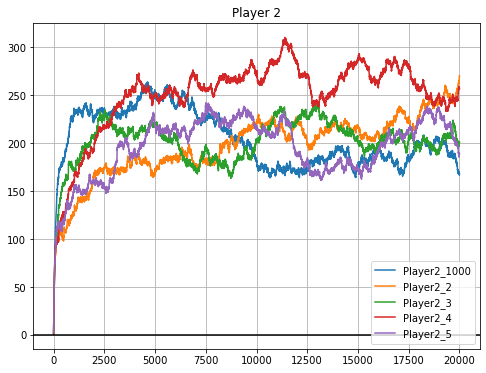

In [16]:
data = pd.read_csv('2_UCB1_Dirichlet_Degenerate_Geom.csv').drop('Unnamed: 0', axis = 1)
two_regrets(data)

In [17]:
n_rounds = 20000
all_nums = [2,3,4,5]
com_freqs = [[1000 for i in range(n_rounds)]]
for n in all_nums:
    exps = []
    for i in range(1, n_rounds):
        if n**i > n_rounds:
            break
        else:
            exps.append(n**i)
    com_freqs.append(exps)

n_arms = 10
beta = 1
n_variables = 2
n_players = 2
n_iterations = 50
dist = 'Bernoulli'
title = 'UCB1_Bernoulli_Geom'

multiple_ucb_1(n_arms = n_arms, n_variables = n_variables, n_players = n_players, n_rounds = n_rounds, n_iterations = n_iterations, com_freqs = com_freqs, title = title, beta = beta, dist = dist)

100%|█████████████████████████████████████████████████████████████████████████████████| 5/5 [1:08:10<00:00, 818.05s/it]


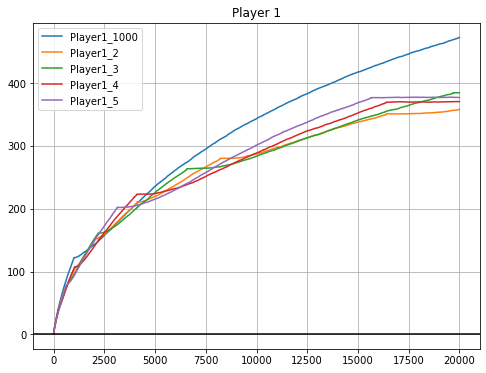

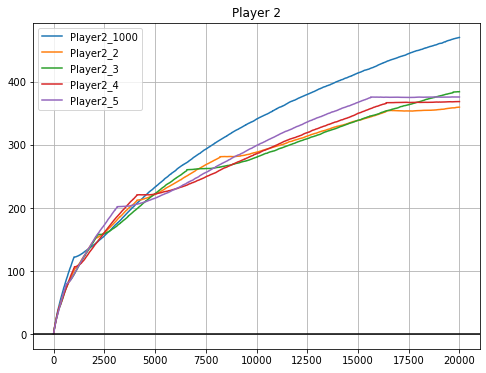

In [18]:
data = pd.read_csv('2_UCB1_Bernoulli_Geom.csv').drop('Unnamed: 0', axis = 1)
two_regrets(data)

In [21]:
n_rounds = 20000
all_nums = [2,3,4,5]
com_freqs = [[1000 for i in range(n_rounds)]]
for n in all_nums:
    exps = []
    for i in range(1, n_rounds):
        if n**i > n_rounds:
            break
        else:
            exps.append(n**i)
    com_freqs.append(exps)
    
n_arms = 10
beta = 2
n_players = 2
n_iterations = 50
dist = 'Poisson'
title = 'UCB1_Poisson_1_Geom'
lambdas = np.arange(1,11,1)

multiple_ucb_1(n_arms = n_arms, n_players = n_players, n_rounds = n_rounds, n_iterations = n_iterations, com_freqs = com_freqs, title = title, beta = beta, dist = dist, lambdas = lambdas)

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [41:40<00:00, 500.07s/it]


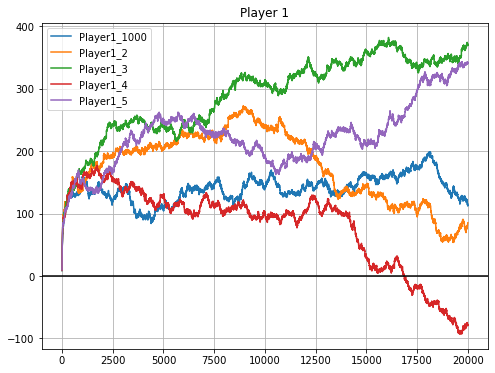

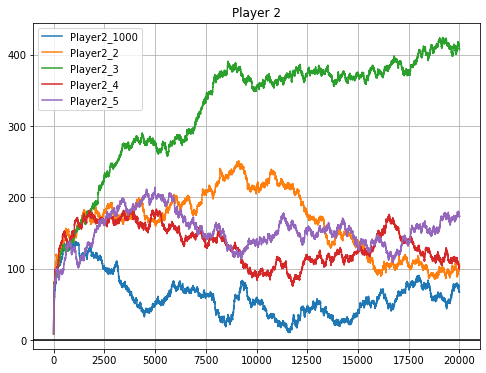

In [22]:
data = pd.read_csv('2_UCB1_Poisson_1_Geom.csv').drop('Unnamed: 0', axis = 1)
two_regrets(data)

In [105]:
n_rounds = 20000
all_nums = [2,3,4,5]
com_freqs = [[1000 for i in range(n_rounds)]]
for n in all_nums:
    exps = []
    for i in range(1, n_rounds):
        if n**i > n_rounds:
            break
        else:
            exps.append(n**i)
    com_freqs.append(exps)
    
n_arms = 10
beta = 4
n_players = 2
n_iterations = 100
dist = 'Exponential'
title = 'UCB1_Exponential_1_Geom'
lambdas = np.arange(1,11,1)

multiple_ucb_1(n_arms = n_arms, n_players = n_players, n_rounds = n_rounds, n_iterations = n_iterations, com_freqs = com_freqs, title = title, beta = beta, dist = dist, lambdas = lambdas)

100%|█████████████████████████████████████████████████████████████████████████████████| 5/5 [1:21:03<00:00, 972.78s/it]


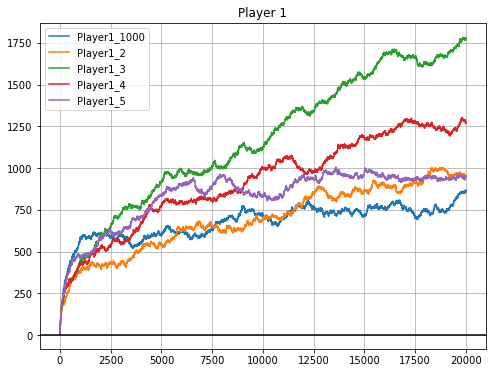

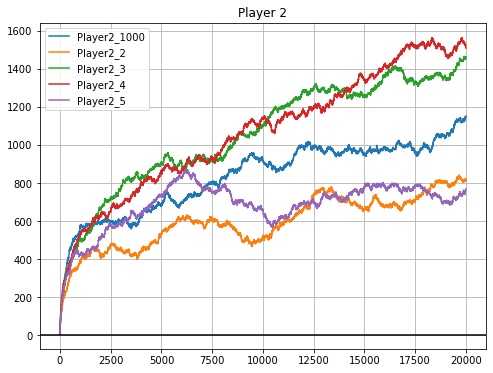

In [106]:
data = pd.read_csv('2_UCB1_Exponential_1_Geom.csv').drop('Unnamed: 0', axis = 1)
two_regrets(data)

## Information Types

### Dirichlet Uniform

In [84]:
n_rounds = 30000
com_freqs = []
exps = []
n = 2
for i in range(1, n_rounds):
    if n**i > n_rounds:
        break
    else:
        exps.append(n**i)
com_freqs.append(exps)

n_arms = 10
beta = 2
n_variables = 10
conc = 10
n_players = 2
n_iterations = 100
dist = 'Dirichlet'
player_type = 'ucb1'
infos = ['all', 'best', 'random', 'second-best', 'sub-optimal']
for info in infos:
    title = 'UCB1_Dirichlet_Uniform_' + info
    multiple_experiment(n_arms = n_arms, n_variables = n_variables, n_players = n_players, n_rounds = n_rounds, n_iterations = n_iterations, com_freqs = com_freqs, title = title, beta = beta, conc = conc, dist = dist, player_type = player_type, info = info)

100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [28:23<00:00, 1703.36s/it]


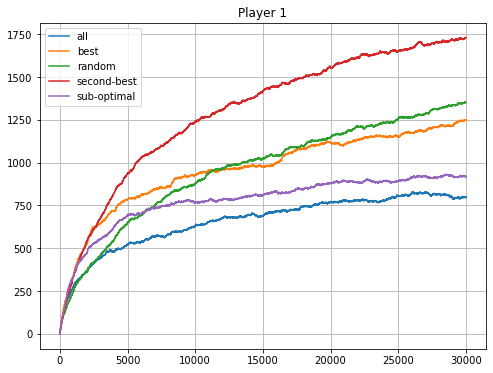

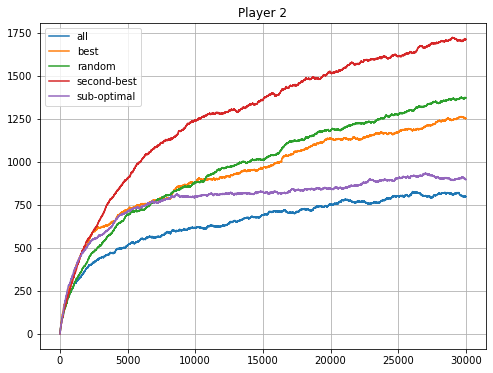

In [173]:
infos = ['all','best', 'random', 'second-best', 'sub-optimal']
plt.figure(figsize = (8,6))
for info in infos:
    file_name = '2_UCB1_Dirichlet_Uniform_' + info + '.csv'
    file = pd.read_csv(file_name).drop('Unnamed: 0', axis = 1)
    plt.plot(file.loc[:, 'p1_2_regrets'], label = info)
    plt.legend()
plt.grid()
plt.title('Player 1')
plt.show()
plt.figure(figsize = (8,6))
for info in infos:
    file_name = '2_UCB1_Dirichlet_Uniform_' + info + '.csv'
    file = pd.read_csv(file_name).drop('Unnamed: 0', axis = 1)
    plt.plot(file.loc[:, 'p2_2_regrets'], label = info)
    plt.legend()
plt.title('Player 2')
plt.grid()
plt.show()

In [136]:
n_rounds = 30000
com_freqs = []
exps = []
n = 2
for i in range(1, n_rounds):
    if n**i > n_rounds:
        break
    else:
        exps.append(n**i)
com_freqs.append(exps)

n_arms = 10
single = True
beta = 2
n_variables = 10
conc = 10
n_players = 2
n_iterations = 100
dist = 'Dirichlet'
player_type = 'ucb1'
infos = ['all', 'best', 'random', 'second-best', 'sub-optimal']
for info in infos:
    title = 'UCB1_Dirichlet_Uniform_Single' + info
    multiple_experiment(n_arms = n_arms, n_variables = n_variables, n_players = n_players, n_rounds = n_rounds, n_iterations = n_iterations, com_freqs = com_freqs, title = title, beta = beta, conc = conc, dist = dist, player_type = player_type, info = info, single = single)

100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [25:40<00:00, 1540.66s/it]


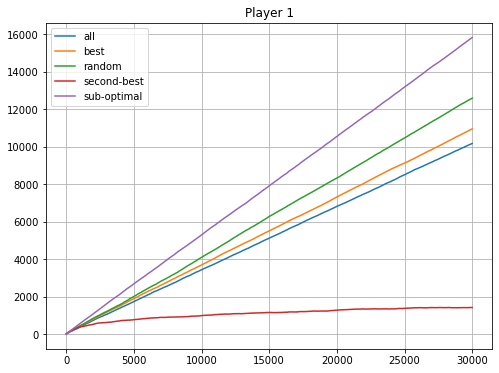

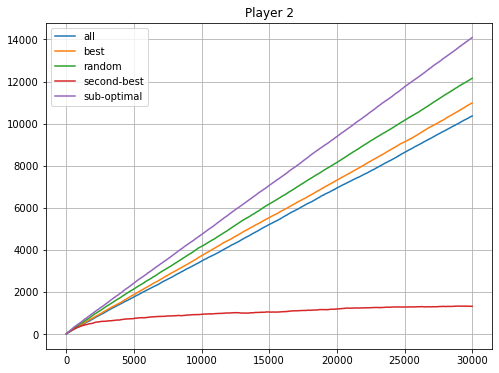

In [186]:
infos = ['all','best', 'random', 'second-best', 'sub-optimal']
plt.figure(figsize = (8,6))
for info in infos:
    file_name = '2_UCB1_Dirichlet_Uniform_Single' + info + '.csv'
    file = pd.read_csv(file_name).drop('Unnamed: 0', axis = 1)
    plt.plot(file.loc[:, 'p1_2_regrets'], label = info)
    plt.legend()
plt.grid()
plt.title('Player 1')
plt.show()
plt.figure(figsize = (8,6))
for info in infos:
    file_name = '2_UCB1_Dirichlet_Uniform_Single' + info + '.csv'
    file = pd.read_csv(file_name).drop('Unnamed: 0', axis = 1)
    plt.plot(file.loc[:, 'p2_2_regrets'], label = info)
    plt.legend()
plt.grid()
plt.title('Player 2')
plt.show()

In [149]:
n_rounds = 30000
com_freqs = []
exps = []
n = 2
for i in range(1, n_rounds):
    if n**i > n_rounds:
        break
    else:
        exps.append(n**i)
com_freqs.append(exps)

n_arms = 10
beta = 2
n_variables = 10
conc = 10
n_players = 2
n_iterations = 100
dist = 'Dirichlet'
player_type = 'ucb1'
infos = [0,1]
singles = [True, False]
for info in infos:
    for single in singles:
        title = 'UCB1_Dirichlet_Uniform_Single' + str(info) + '_' + str(single)
        multiple_experiment(n_arms = n_arms, n_variables = n_variables, n_players = n_players, n_rounds = n_rounds, n_iterations = n_iterations, com_freqs = com_freqs, title = title, beta = beta, conc = conc, dist = dist, player_type = player_type, info = info, single = single)

100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [27:14<00:00, 1634.24s/it]


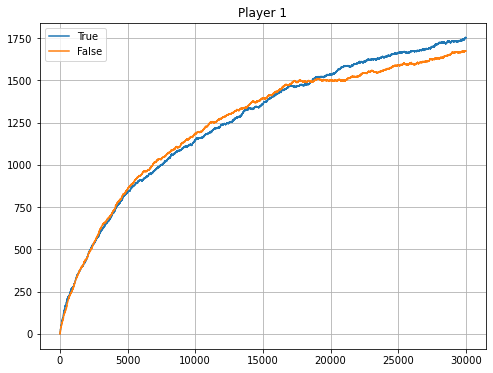

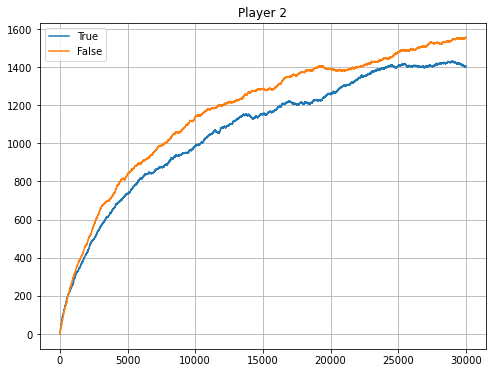

In [188]:
info = 0
singles = [True, False]
plt.figure(figsize = (8,6))
for single in singles:
    file_name = '2_UCB1_Dirichlet_Uniform_Single' + str(info) + '_' + str(single) + '.csv'
    file = pd.read_csv(file_name).drop('Unnamed: 0', axis = 1)
    plt.plot(file.loc[:, 'p1_2_regrets'], label = single)
    plt.legend()
plt.grid()
plt.title('Player 1')
plt.show()
plt.figure(figsize = (8,6))
info = 0
for single in singles:
    file_name = '2_UCB1_Dirichlet_Uniform_Single' + str(info) + '_' + str(single) + '.csv'
    file = pd.read_csv(file_name).drop('Unnamed: 0', axis = 1)
    plt.plot(file.loc[:, 'p2_2_regrets'], label = single)
    plt.legend()
plt.grid()
plt.title('Player 2')
plt.show()

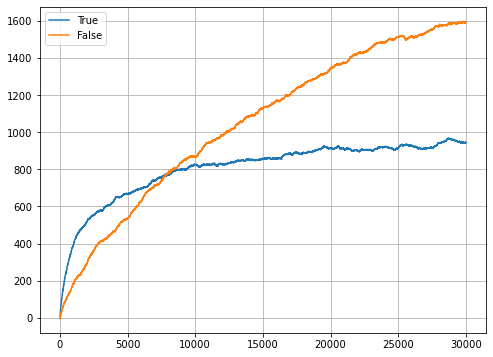

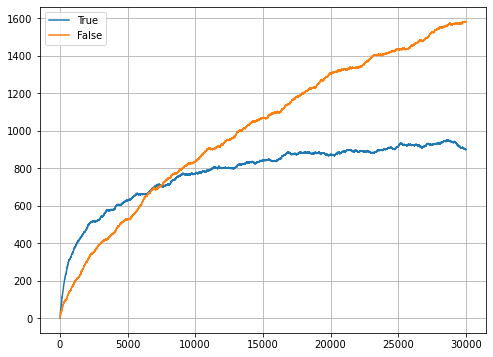

In [162]:
info = 1
singles = [True, False]
plt.figure(figsize = (8,6))
for single in singles:
    file_name = '2_UCB1_Dirichlet_Uniform_Single' + str(info) + '_' + str(single) + '.csv'
    file = pd.read_csv(file_name).drop('Unnamed: 0', axis = 1)
    plt.plot(file.loc[:, 'p1_2_regrets'], label = single)
    plt.legend()
plt.grid()
plt.show()
plt.figure(figsize = (8,6))
for single in singles:
    file_name = '2_UCB1_Dirichlet_Uniform_Single' + str(info) + '_' + str(single) + '.csv'
    file = pd.read_csv(file_name).drop('Unnamed: 0', axis = 1)
    plt.plot(file.loc[:, 'p2_2_regrets'], label = single)
    plt.legend()
plt.grid()
plt.show()

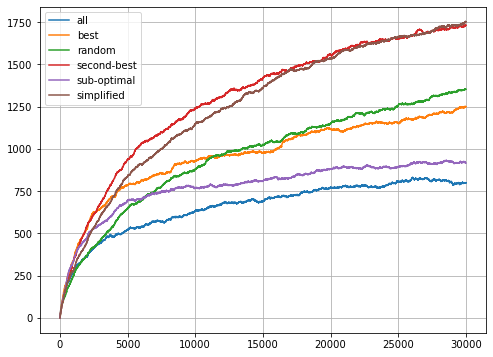

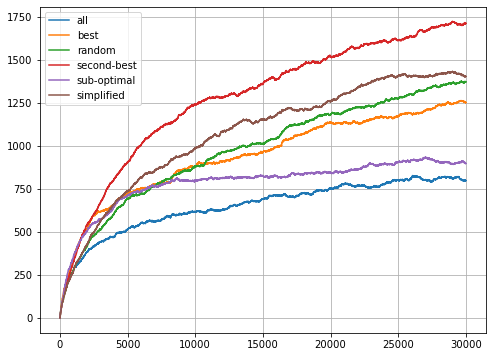

In [187]:
infos = ['all','best', 'random', 'second-best', 'sub-optimal']
init_arm = 0
plt.figure(figsize = (8,6))
for info in infos:
    file_name = '2_UCB1_Dirichlet_Uniform_' + info + '.csv'
    file = pd.read_csv(file_name).drop('Unnamed: 0', axis = 1)
    plt.plot(file.loc[:, 'p1_2_regrets'], label = info)
    plt.legend()
    
file_name = '2_UCB1_Dirichlet_Uniform_Single' + str(init_arm) + '_' + str(True) + '.csv'
file = pd.read_csv(file_name).drop('Unnamed: 0', axis = 1)
plt.plot(file.loc[:, 'p1_2_regrets'], label = 'simplified')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize = (8,6))
for info in infos:
    file_name = '2_UCB1_Dirichlet_Uniform_' + info + '.csv'
    file = pd.read_csv(file_name).drop('Unnamed: 0', axis = 1)
    plt.plot(file.loc[:, 'p2_2_regrets'], label = info)
    plt.legend()
file_name = '2_UCB1_Dirichlet_Uniform_Single' + str(init_arm) + '_' + str(True) + '.csv'
file = pd.read_csv(file_name).drop('Unnamed: 0', axis = 1)
plt.plot(file.loc[:, 'p2_2_regrets'], label = 'simplified')
plt.legend()
plt.grid()
plt.show()

### Exponential

In [153]:
n_rounds = 30000
com_freqs = []
exps = []
n = 2
for i in range(1, n_rounds):
    if n**i > n_rounds:
        break
    else:
        exps.append(n**i)
com_freqs.append(exps)

n_arms = 10
beta = 4
n_variables = 10
n_players = 2
n_iterations = 100
dist = 'Exponential'
player_type = 'ucb1'
lambdas = np.arange(1,11,1)
infos = ['all', 'best', 'random', 'second-best', 'sub-optimal']
for info in infos:
    title = 'UCB1_Exponential_1_' + info
    multiple_experiment(n_arms = n_arms, n_variables = n_variables, n_players = n_players, n_rounds = n_rounds, n_iterations = n_iterations, com_freqs = com_freqs, title = title, beta = beta, dist = dist, player_type = player_type, info = info, lambdas = lambdas)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [12:26<00:00, 746.75s/it]


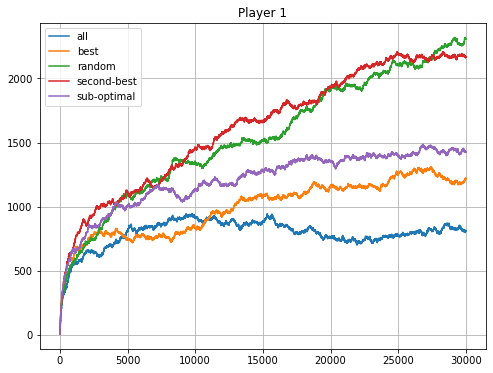

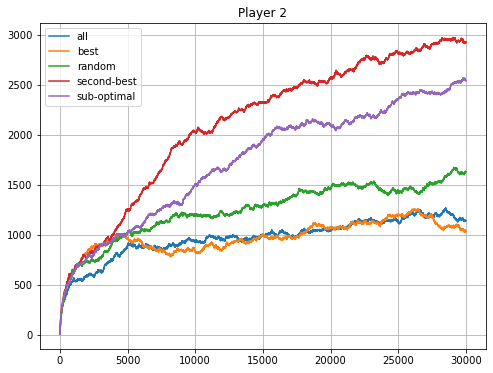

In [182]:
infos = ['all','best', 'random', 'second-best', 'sub-optimal']
plt.figure(figsize = (8,6))
for info in infos:
    file_name = '2_UCB1_Exponential_1_' + info + '.csv'
    file = pd.read_csv(file_name).drop('Unnamed: 0', axis = 1)
    plt.plot(file.loc[:, 'p1_2_regrets'], label = info)
    plt.legend()
plt.grid()
plt.title('Player 1')
plt.show()
plt.figure(figsize = (8,6))
for info in infos:
    file_name = '2_UCB1_Exponential_1_' + info + '.csv'
    file = pd.read_csv(file_name).drop('Unnamed: 0', axis = 1)
    plt.plot(file.loc[:, 'p2_2_regrets'], label = info)
    plt.legend()
plt.grid()
plt.title('Player 2')
plt.show()

In [138]:
n_rounds = 30000
com_freqs = []
exps = []
n = 2
for i in range(1, n_rounds):
    if n**i > n_rounds:
        break
    else:
        exps.append(n**i)
com_freqs.append(exps)

single = True
n_arms = 10
beta = 4
n_variables = 10
n_players = 2
n_iterations = 100
dist = 'Exponential'
player_type = 'ucb1'
lambdas = np.arange(1,11,1)
infos = ['all', 'best', 'random', 'second-best', 'sub-optimal']
for info in infos:
    title = 'UCB1_Exponential_1_Single' + info
    multiple_experiment(n_arms = n_arms, n_variables = n_variables, n_players = n_players, n_rounds = n_rounds, n_iterations = n_iterations, com_freqs = com_freqs, title = title, beta = beta, dist = dist, player_type = player_type, info = info, lambdas = lambdas, single = single)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [10:14<00:00, 614.59s/it]


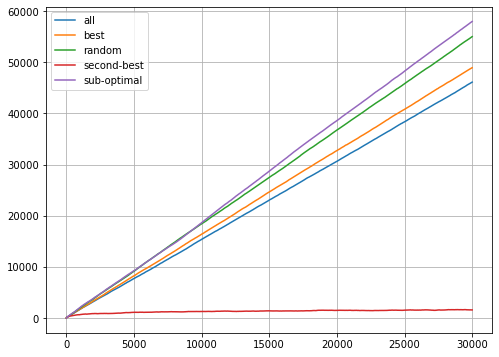

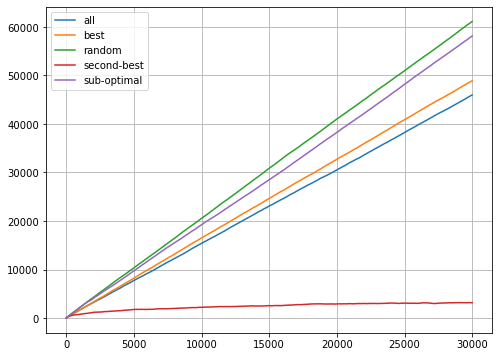

In [139]:
infos = ['all','best', 'random', 'second-best', 'sub-optimal']
plt.figure(figsize = (8,6))
for info in infos:
    file_name = '2_UCB1_Exponential_1_Single' + info + '.csv'
    file = pd.read_csv(file_name).drop('Unnamed: 0', axis = 1)
    plt.plot(file.loc[:, 'p1_2_regrets'], label = info)
    plt.legend()
plt.grid()
plt.show()
plt.figure(figsize = (8,6))
for info in infos:
    file_name = '2_UCB1_Exponential_1_Single' + info + '.csv'
    file = pd.read_csv(file_name).drop('Unnamed: 0', axis = 1)
    plt.plot(file.loc[:, 'p2_2_regrets'], label = info)
    plt.legend()
plt.grid()
plt.show()

In [150]:
n_rounds = 30000
com_freqs = []
exps = []
n = 2
for i in range(1, n_rounds):
    if n**i > n_rounds:
        break
    else:
        exps.append(n**i)
com_freqs.append(exps)

n_arms = 10
beta = 4
n_variables = 10
n_players = 2
n_iterations = 100
lambdas = np.arange(1,11,1)
dist = 'Exponential'
player_type = 'ucb1'
infos = [0,1]
singles = [True, False]
for info in infos:
    for single in singles:
        title = 'UCB1_Exponential_1_Single' + str(info) + '_' + str(single)
        multiple_experiment(n_arms = n_arms, n_variables = n_variables, n_players = n_players, n_rounds = n_rounds, n_iterations = n_iterations, com_freqs = com_freqs, title = title, beta = beta, lambdas = lambdas, dist = dist, player_type = player_type, info = info, single = single)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [11:27<00:00, 687.66s/it]


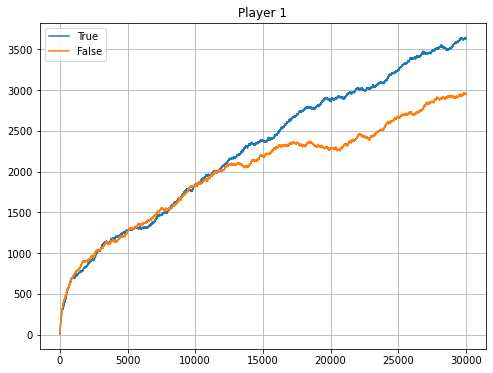

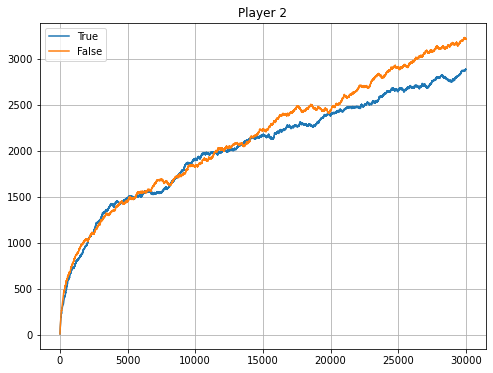

In [189]:
info = 0
singles = [True, False]
plt.figure(figsize = (8,6))
for single in singles:
    file_name = '2_UCB1_Exponential_1_Single' + str(info) + '_' + str(single) + '.csv'
    file = pd.read_csv(file_name).drop('Unnamed: 0', axis = 1)
    plt.plot(file.loc[:, 'p1_2_regrets'], label = single)
    plt.legend()
plt.grid()
plt.title('Player 1')
plt.show()
plt.figure(figsize = (8,6))
for single in singles:
    file_name = '2_UCB1_Exponential_1_Single' + str(info) + '_' + str(single) + '.csv'
    file = pd.read_csv(file_name).drop('Unnamed: 0', axis = 1)
    plt.plot(file.loc[:, 'p2_2_regrets'], label = single)
    plt.legend()
plt.grid()
plt.title('Player 2')
plt.show()

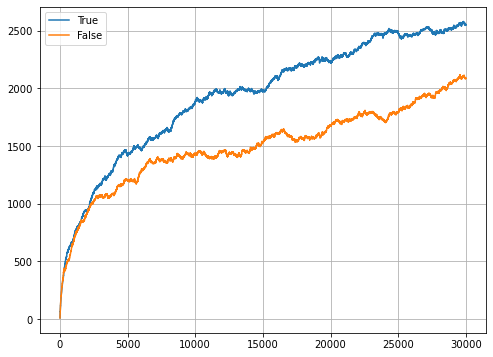

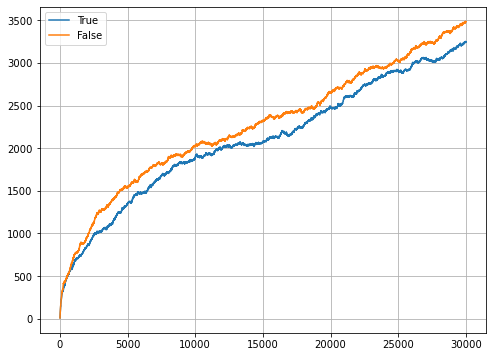

In [172]:
info = 1
singles = [True, False]
plt.figure(figsize = (8,6))
for single in singles:
    file_name = '2_UCB1_Exponential_1_Single' + str(info) + '_' + str(single) + '.csv'
    file = pd.read_csv(file_name).drop('Unnamed: 0', axis = 1)
    plt.plot(file.loc[:, 'p1_2_regrets'], label = single)
    plt.legend()
plt.grid()
plt.show()
plt.figure(figsize = (8,6))
for single in singles:
    file_name = '2_UCB1_Exponential_1_Single' + str(info) + '_' + str(single) + '.csv'
    file = pd.read_csv(file_name).drop('Unnamed: 0', axis = 1)
    plt.plot(file.loc[:, 'p2_2_regrets'], label = single)
    plt.legend()
plt.grid()
plt.show()

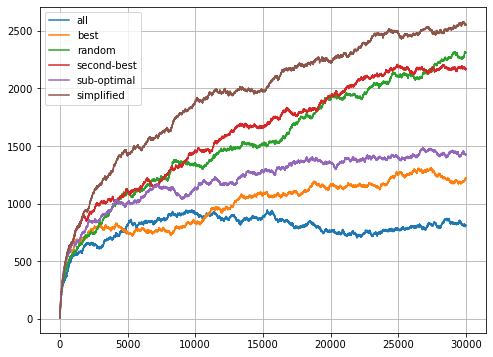

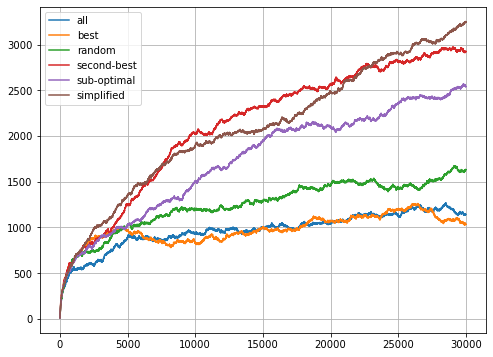

In [176]:
infos = ['all','best', 'random', 'second-best', 'sub-optimal']
init_arm = 1
plt.figure(figsize = (8,6))
for info in infos:
    file_name = '2_UCB1_Exponential_1_' + info + '.csv'
    file = pd.read_csv(file_name).drop('Unnamed: 0', axis = 1)
    plt.plot(file.loc[:, 'p1_2_regrets'], label = info)
    plt.legend()
    
file_name = '2_UCB1_Exponential_1_Single' + str(init_arm) + '_' + str(True) + '.csv'
file = pd.read_csv(file_name).drop('Unnamed: 0', axis = 1)
plt.plot(file.loc[:, 'p1_2_regrets'], label = 'simplified')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize = (8,6))
for info in infos:
    file_name = '2_UCB1_Exponential_1_' + info + '.csv'
    file = pd.read_csv(file_name).drop('Unnamed: 0', axis = 1)
    plt.plot(file.loc[:, 'p2_2_regrets'], label = info)
    plt.legend()
file_name = '2_UCB1_Exponential_1_Single' + str(init_arm) + '_' + str(True) + '.csv'
file = pd.read_csv(file_name).drop('Unnamed: 0', axis = 1)
plt.plot(file.loc[:, 'p2_2_regrets'], label = 'simplified')
plt.legend()
plt.grid()
plt.show()

# UCB-V

In [141]:
class ucb_v_player(player_m):
    def __init__(self, n_arms, beta, player_index, n_players, n_rounds):
        super().__init__(n_arms, player_index, n_players, n_rounds)
        self.beta = beta
        self.ucbs = np.zeros(shape = n_arms)
        self.variances = np.zeros(shape = n_arms)
        self.means_squared = np.zeros(shape = n_arms)
    
    def compute_ucbs(self, current_round):
        ucb_1 = np.sqrt((2*np.log(current_round)*self.variances[self.n_trials > 0])/self.n_trials[self.n_trials > 0])
        ucb_2 = 3*np.log(current_round)*self.beta/self.n_trials[self.n_trials > 0]
        self.ucbs[self.n_trials > 0] = ucb_1 + ucb_2
        
    def choice(self):
        choice = np.argmax(self.means + self.ucbs)
        self.choices.append(choice)
        return choice
    
    def receive_reward(self, other_reward, index = None, single = False):
        if single is True:
            if index is None:
                self.all_rewards[(self.all_rewards == 0) & (other_reward != 0)] = other_reward[(self.all_rewards == 0) & (other_reward != 0)]
                self.means = self.all_rewards.sum(axis = 2).sum(axis = 1)/self.n_players*self.n_trials
                self.means_squared = (self.all_rewards**2).sum(axis = 2).sum(axis = 1)/self.n_players*self.n_trials
            else:
                self.all_rewards[(self.all_rewards == 0) & (other_reward != 0)] = other_reward[(self.all_rewards == 0) & (other_reward != 0)]
                self.means[index] = self.all_rewards.sum(axis = 2).sum(axis = 1)[index]/self.n_players*self.n_trials[index]
                self.means_squared[index] = (self.all_rewards**2).sum(axis = 2).sum(axis = 1)[index]/self.n_players*self.n_trials[index]
    
        else:
            if index is None:
                self.all_rewards[(self.all_rewards == 0) & (other_reward != 0)] = other_reward[(self.all_rewards == 0) & (other_reward != 0)]
                self.means = self.all_rewards.sum(axis = 2).sum(axis = 1)/self.n_trials
                self.means_squared = (self.all_rewards**2).sum(axis = 2).sum(axis = 1)/self.n_trials
            else:
                self.all_rewards[(self.all_rewards == 0) & (other_reward != 0)] = other_reward[(self.all_rewards == 0) & (other_reward != 0)]
                self.means[index] = self.all_rewards.sum(axis = 2).sum(axis = 1)[index]/self.n_trials[index]
                self.means_squared[index] = (self.all_rewards**2).sum(axis = 2).sum(axis = 1)[index]/self.n_trials[index]
    
    def update_mean(self, choice, reward, current_round):
        if choice != None:
            self.all_rewards[choice, self.player_index, current_round] = reward
            increment = (reward - self.means[choice])/self.n_trials[choice]
            self.means[choice] += increment
            increment_squared = (reward**2 - self.means_squared[choice])/self.n_trials[choice]
            self.means_squared[choice] += increment_squared
    
    def update_variance(self, choice):
        self.variances[choice] = self.means_squared[choice] - self.means[choice]**2

In [26]:
n_arms = 10
n_variables = 10
beta = 1
n_rounds = 20000
all_nums = [2,3,4,5]
com_freqs = [[1000 for i in range(n_rounds)]]
for n in all_nums:
    exps = []
    for i in range(1, n_rounds):
        if n**i > n_rounds:
            break
        else:
            exps.append(n**i)
    com_freqs.append(exps)
n_players = 2
n_iterations = 50
dist = 'Dirichlet'
title = 'UCBV_Dirichlet_Base_Geom'
conc = 0.5
player_type = 'ucbv'
multiple_experiment(n_arms = n_arms, n_variables = n_variables, n_players = n_players, n_rounds = n_rounds, n_iterations = n_iterations, com_freqs = com_freqs, title = title, beta = beta, dist = dist, player_type = player_type, conc = conc)

100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [1:46:07<00:00, 1273.58s/it]


In [114]:
n_arms = 10
n_variables = 10
beta = 1
n_rounds = 20000
all_nums = [2,3,4,5]
com_freqs = [[1000 for i in range(n_rounds)]]
for n in all_nums:
    exps = []
    for i in range(1, n_rounds):
        if n**i > n_rounds:
            break
        else:
            exps.append(n**i)
    com_freqs.append(exps)
n_players = 2
n_iterations = 100
dist = 'Dirichlet'
title = 'UCBV_Dirichlet_Uniform_Geom'
conc = 10
player_type = 'ucbv'
multiple_experiment(n_arms = n_arms, n_variables = n_variables, n_players = n_players, n_rounds = n_rounds, n_iterations = n_iterations, com_freqs = com_freqs, title = title, beta = beta, dist = dist, player_type = player_type, conc = conc)

100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [2:50:25<00:00, 2045.13s/it]


In [28]:
n_arms = 10
n_variables = 10
beta = 1
n_rounds = 20000
all_nums = [2,3,4,5]
com_freqs = [[1000 for i in range(n_rounds)]]
for n in all_nums:
    exps = []
    for i in range(1, n_rounds):
        if n**i > n_rounds:
            break
        else:
            exps.append(n**i)
    com_freqs.append(exps)
n_players = 2
n_iterations = 50
dist = 'Dirichlet'
title = 'UCBV_Dirichlet_Degenerate_Geom'
conc = 0.1
player_type = 'ucbv'
multiple_experiment(n_arms = n_arms, n_variables = n_variables, n_players = n_players, n_rounds = n_rounds, n_iterations = n_iterations, com_freqs = com_freqs, title = title, beta = beta, dist = dist, player_type = player_type, conc = conc)

100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [1:26:55<00:00, 1043.01s/it]


In [29]:
n_arms = 10
beta = 0
n_variables = 2
n_rounds = 20000
n_players = 2
n_iterations = 50
dist = 'Bernoulli'
title = 'UCBV_Bernoulli_Geom'
player_type = 'ucbv'

multiple_experiment(n_arms = n_arms, n_variables = n_variables, n_players = n_players, n_rounds = n_rounds, n_iterations = n_iterations, com_freqs = com_freqs, title = title, beta = beta, player_type = player_type, dist = dist)

100%|█████████████████████████████████████████████████████████████████████████████████| 5/5 [1:16:24<00:00, 916.98s/it]


In [30]:
n_arms = 10
beta = 1
n_rounds = 20000
all_nums = [2,3,4,5]
com_freqs = [[1000 for i in range(n_rounds)]]
for n in all_nums:
    exps = []
    for i in range(1, n_rounds):
        if n**i > n_rounds:
            break
        else:
            exps.append(n**i)
    com_freqs.append(exps)
n_players = 2
n_iterations = 50
dist = 'Poisson'
title = 'UCBV_Poisson_1_Geom'
player_type = 'ucbv'
lambdas = np.arange(1,11,1)

multiple_experiment(n_arms = n_arms, n_players = n_players, n_rounds = n_rounds, n_iterations = n_iterations, com_freqs = com_freqs, title = title, beta = beta, dist = dist, player_type = player_type, lambdas = lambdas)

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [44:51<00:00, 538.26s/it]


In [115]:
n_arms = 10
beta = 3
n_rounds = 20000
all_nums = [2,3,4]
com_freqs = [[1000 for i in range(n_rounds)]]
for n in all_nums:
    exps = []
    for i in range(1, n_rounds):
        if n**i > n_rounds:
            break
        else:
            exps.append(n**i)
    com_freqs.append(exps)
n_players = 2
n_iterations = 100
dist = 'Poisson'
title = 'UCBV_Exponential_1_Geom'
player_type = 'ucbv'
lambdas = np.arange(1,11,1)

multiple_experiment(n_arms = n_arms, n_players = n_players, n_rounds = n_rounds, n_iterations = n_iterations, com_freqs = com_freqs, title = title, beta = beta, dist = dist, player_type = player_type, lambdas = lambdas)

100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [1:30:52<00:00, 1363.20s/it]


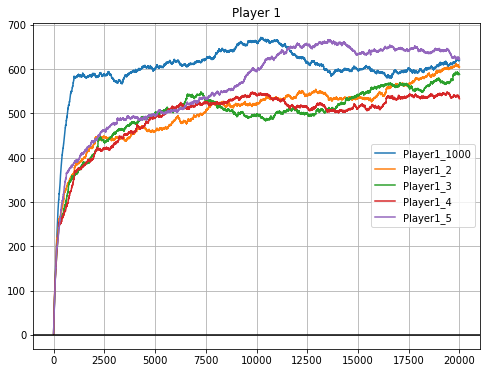

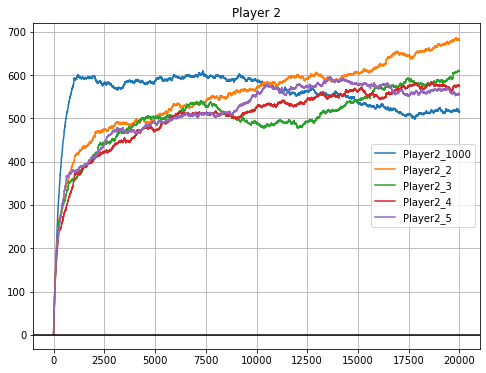

In [33]:
data = pd.read_csv('2_UCBV_Dirichlet_Base_Geom.csv').drop('Unnamed: 0', axis = 1)
two_regrets(data)

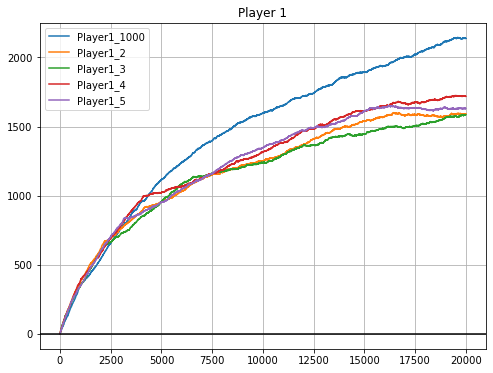

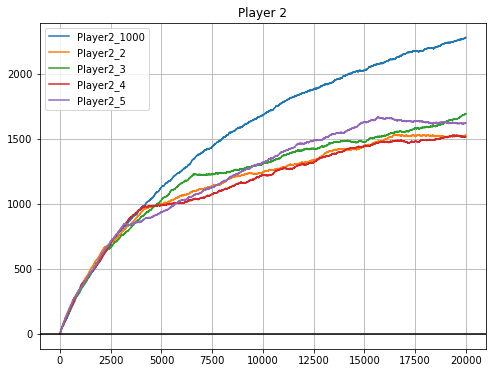

In [116]:
data = pd.read_csv('2_UCBV_Dirichlet_Uniform_Geom.csv').drop('Unnamed: 0', axis = 1)
two_regrets(data)

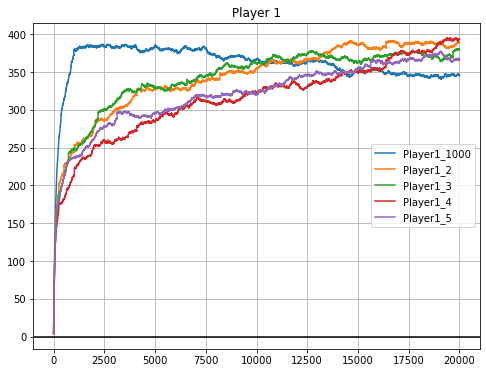

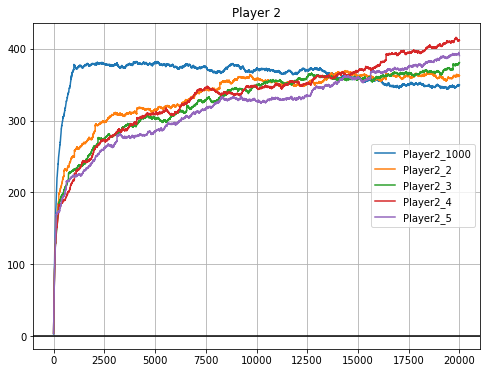

In [35]:
data = pd.read_csv('2_UCBV_Dirichlet_Degenerate_Geom.csv').drop('Unnamed: 0', axis = 1)
two_regrets(data)

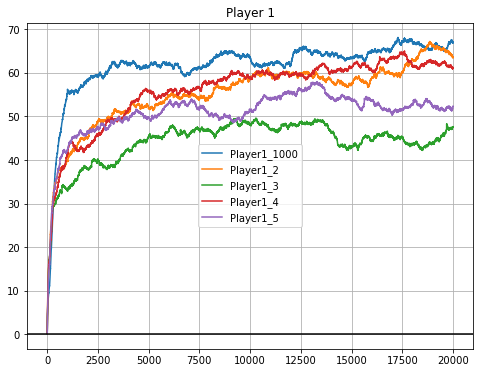

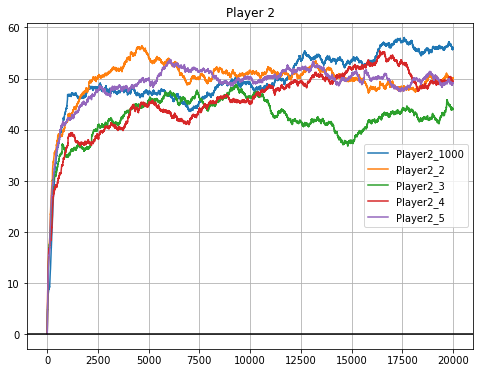

In [38]:
data = pd.read_csv('2_UCBV_Bernoulli_Geom.csv').drop('Unnamed: 0', axis = 1)
two_regrets(data)

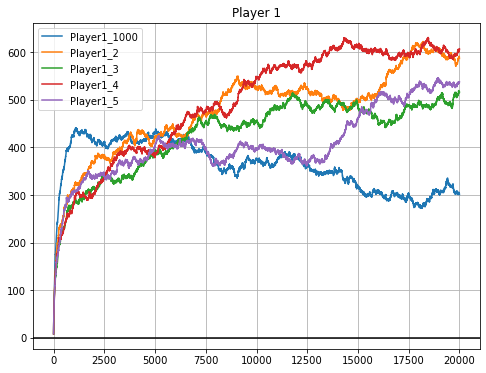

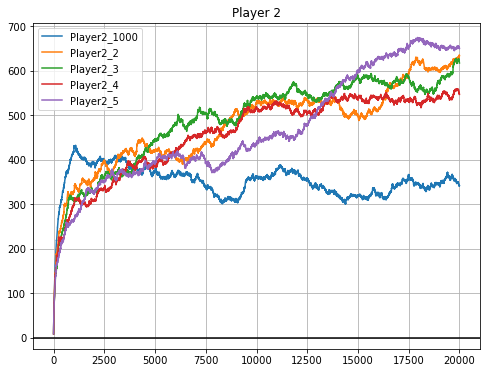

In [36]:
data = pd.read_csv('2_UCBV_Poisson_1_Geom.csv').drop('Unnamed: 0', axis = 1)
two_regrets(data)

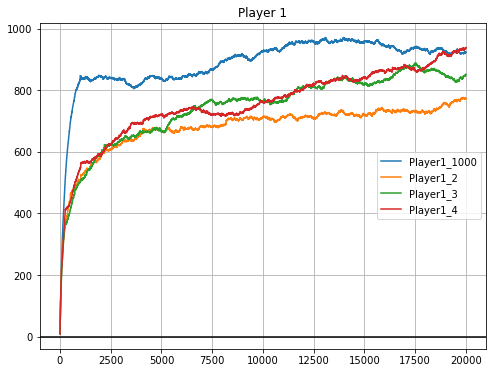

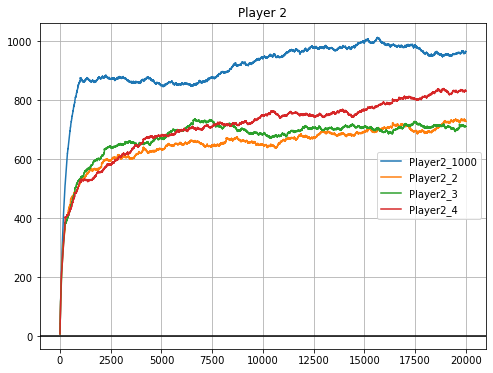

In [117]:
data = pd.read_csv('2_UCBV_Exponential_1_Geom.csv').drop('Unnamed: 0', axis = 1)
two_regrets(data)

## Information Types

### Dirichlet Uniform

In [93]:
n_rounds = 30000
com_freqs = []
exps = []
n = 2
for i in range(1, n_rounds):
    if n**i > n_rounds:
        break
    else:
        exps.append(n**i)
com_freqs.append(exps)

n_arms = 10
beta = 1
n_variables = 10
conc = 10
n_players = 2
n_iterations = 100
dist = 'Dirichlet'
player_type = 'ucbv'
infos = ['all','best', 'random', 'second-best', 'sub-optimal']
for info in infos:
    title = 'UCBV_Dirichlet_Uniform_' + info
    multiple_experiment(n_arms = n_arms, n_variables = n_variables, n_players = n_players, n_rounds = n_rounds, n_iterations = n_iterations, com_freqs = com_freqs, title = title, beta = beta, conc = conc, dist = dist, player_type = player_type, info = info)

100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [33:30<00:00, 2010.23s/it]


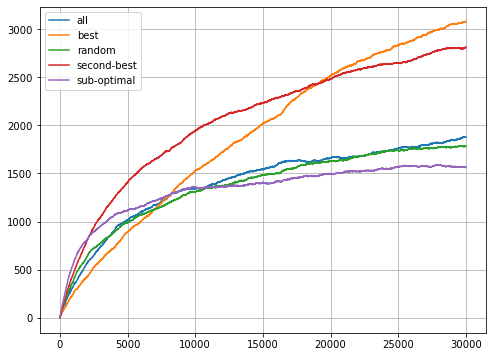

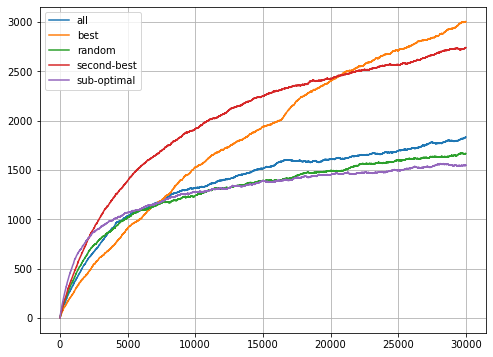

In [101]:
infos = ['all','best', 'random', 'second-best', 'sub-optimal']
plt.figure(figsize = (8,6))
for info in infos:
    file_name = '2_UCBV_Dirichlet_Uniform_' + info + '.csv'
    file = pd.read_csv(file_name).drop('Unnamed: 0', axis = 1)
    plt.plot(file.loc[:, 'p1_2_regrets'], label = info)
    plt.legend()
plt.grid()
plt.show()
plt.figure(figsize = (8,6))
for info in infos:
    file_name = '2_UCBV_Dirichlet_Uniform_' + info + '.csv'
    file = pd.read_csv(file_name).drop('Unnamed: 0', axis = 1)
    plt.plot(file.loc[:, 'p2_2_regrets'], label = info)
    plt.legend()
plt.grid()
plt.show()

In [142]:
n_rounds = 30000
com_freqs = []
exps = []
n = 2
for i in range(1, n_rounds):
    if n**i > n_rounds:
        break
    else:
        exps.append(n**i)
com_freqs.append(exps)

single = True
n_arms = 10
beta = 1
n_variables = 10
conc = 10
n_players = 2
n_iterations = 100
dist = 'Dirichlet'
player_type = 'ucbv'
infos = ['all','best', 'random', 'second-best', 'sub-optimal']
for info in infos:
    title = 'UCBV_Dirichlet_Uniform_Single' + info
    multiple_experiment(n_arms = n_arms, n_variables = n_variables, n_players = n_players, n_rounds = n_rounds, n_iterations = n_iterations, com_freqs = com_freqs, title = title, beta = beta, conc = conc, dist = dist, player_type = player_type, info = info, single = single)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]<ipython-input-141-6597ddcce525>:10: RuntimeWarning: invalid value encountered in sqrt
  ucb_1 = np.sqrt((2*np.log(current_round)*self.variances[self.n_trials > 0])/self.n_trials[self.n_trials > 0])
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]<ipython-input-141-6597ddcce525>:10: RuntimeWarning: invalid value encountered in sqrt
  ucb_1 = np.sqrt((2*np.log(current_round)*self.variances[self.n_trials > 0])/self.n_trials[self.n_trials > 0])
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]<ipython-input-141-6597ddcce525>:10: RuntimeWarning: invalid value encountered in sqrt
  ucb_1 = np.sqrt((2*np.log(current_round)*self.variances[self.n_trials > 0])/self.n_trials[self.n_trials > 0])
  0%|                                         

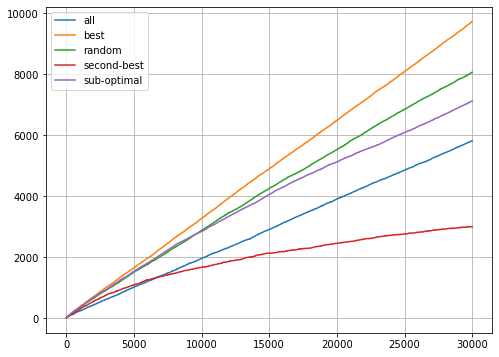

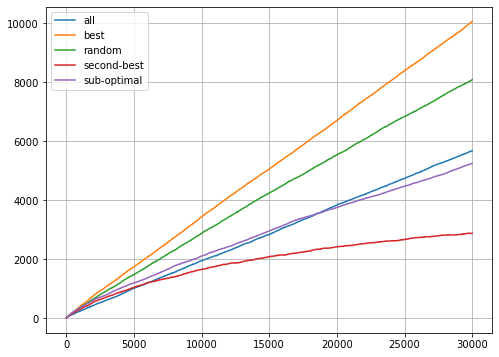

In [143]:
infos = ['all','best', 'random', 'second-best', 'sub-optimal']
plt.figure(figsize = (8,6))
for info in infos:
    file_name = '2_UCBV_Dirichlet_Uniform_Single' + info + '.csv'
    file = pd.read_csv(file_name).drop('Unnamed: 0', axis = 1)
    plt.plot(file.loc[:, 'p1_2_regrets'], label = info)
    plt.legend()
plt.grid()
plt.show()
plt.figure(figsize = (8,6))
for info in infos:
    file_name = '2_UCBV_Dirichlet_Uniform_Single' + info + '.csv'
    file = pd.read_csv(file_name).drop('Unnamed: 0', axis = 1)
    plt.plot(file.loc[:, 'p2_2_regrets'], label = info)
    plt.legend()
plt.grid()
plt.show()

In [151]:
n_rounds = 30000
com_freqs = []
exps = []
n = 2
for i in range(1, n_rounds):
    if n**i > n_rounds:
        break
    else:
        exps.append(n**i)
com_freqs.append(exps)

n_arms = 10
beta = 2
n_variables = 10
conc = 10
n_players = 2
n_iterations = 100
dist = 'Dirichlet'
player_type = 'ucbv'
infos = [0,1]
singles = [True, False]
for info in infos:
    for single in singles:
        title = 'UCBV_Dirichlet_Uniform_Single' + str(info) + '_' + str(single)
        multiple_experiment(n_arms = n_arms, n_variables = n_variables, n_players = n_players, n_rounds = n_rounds, n_iterations = n_iterations, com_freqs = com_freqs, title = title, beta = beta, conc = conc, dist = dist, player_type = player_type, info = info, single = single)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]<ipython-input-141-6597ddcce525>:10: RuntimeWarning: invalid value encountered in sqrt
  ucb_1 = np.sqrt((2*np.log(current_round)*self.variances[self.n_trials > 0])/self.n_trials[self.n_trials > 0])
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]<ipython-input-141-6597ddcce525>:10: RuntimeWarning: invalid value encountered in sqrt
  ucb_1 = np.sqrt((2*np.log(current_round)*self.variances[self.n_trials > 0])/self.n_trials[self.n_trials > 0])
100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [29:58<00:00, 1798.14s/it]


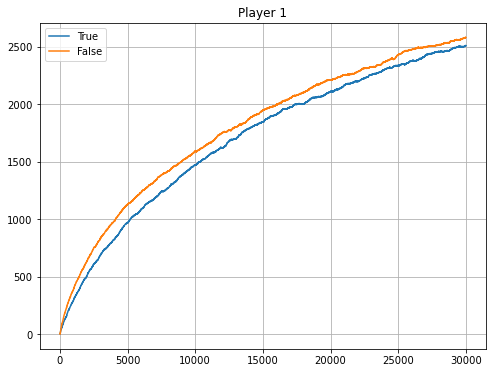

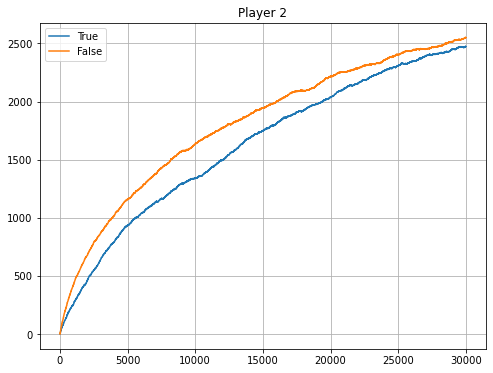

In [190]:
info = 0
singles = [True, False]
plt.figure(figsize = (8,6))
for single in singles:
    file_name = '2_UCBV_Dirichlet_Uniform_Single' + str(info) + '_' + str(single) + '.csv'
    file = pd.read_csv(file_name).drop('Unnamed: 0', axis = 1)
    plt.plot(file.loc[:, 'p1_2_regrets'], label = single)
    plt.legend()
plt.grid()
plt.title('Player 1')
plt.show()
plt.figure(figsize = (8,6))
info = 0
for single in singles:
    file_name = '2_UCBV_Dirichlet_Uniform_Single' + str(info) + '_' + str(single) + '.csv'
    file = pd.read_csv(file_name).drop('Unnamed: 0', axis = 1)
    plt.plot(file.loc[:, 'p2_2_regrets'], label = single)
    plt.legend()
plt.grid()
plt.title('Player 2')
plt.show()

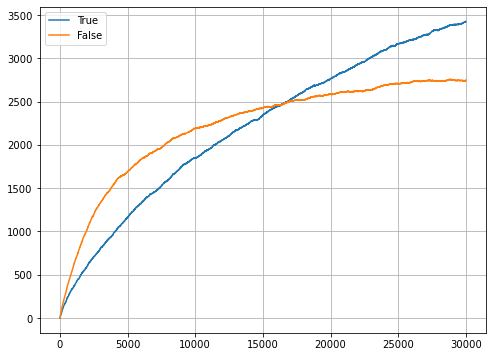

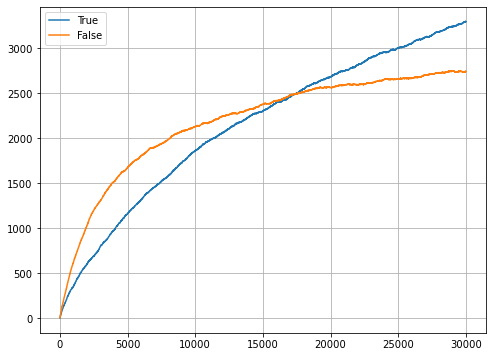

In [165]:
info = 1
singles = [True, False]
plt.figure(figsize = (8,6))
for single in singles:
    file_name = '2_UCBV_Dirichlet_Uniform_Single' + str(info) + '_' + str(single) + '.csv'
    file = pd.read_csv(file_name).drop('Unnamed: 0', axis = 1)
    plt.plot(file.loc[:, 'p1_2_regrets'], label = single)
    plt.legend()
plt.grid()
plt.show()
plt.figure(figsize = (8,6))
for single in singles:
    file_name = '2_UCBV_Dirichlet_Uniform_Single' + str(info) + '_' + str(single) + '.csv'
    file = pd.read_csv(file_name).drop('Unnamed: 0', axis = 1)
    plt.plot(file.loc[:, 'p2_2_regrets'], label = single)
    plt.legend()
plt.grid()
plt.show()

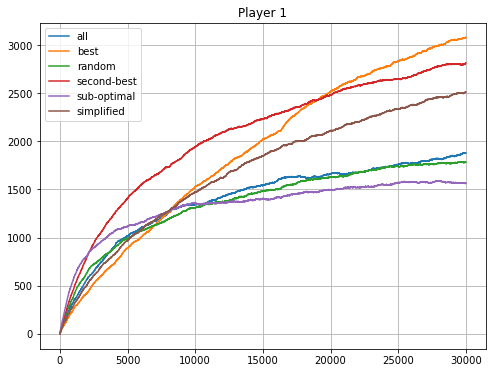

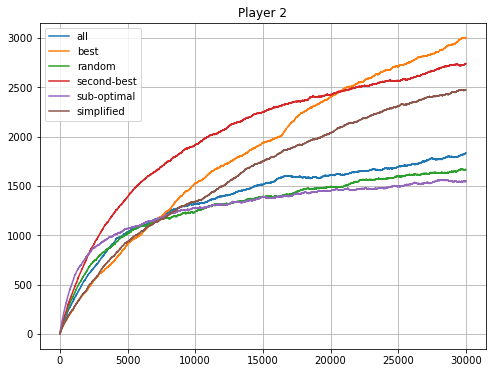

In [183]:
infos = ['all','best', 'random', 'second-best', 'sub-optimal']
init_arm = 0
plt.figure(figsize = (8,6))
for info in infos:
    file_name = '2_UCBV_Dirichlet_Uniform_' + info + '.csv'
    file = pd.read_csv(file_name).drop('Unnamed: 0', axis = 1)
    plt.plot(file.loc[:, 'p1_2_regrets'], label = info)
    plt.legend()
    
file_name = '2_UCBV_Dirichlet_Uniform_Single' + str(init_arm) + '_' + str(True) + '.csv'
file = pd.read_csv(file_name).drop('Unnamed: 0', axis = 1)
plt.plot(file.loc[:, 'p1_2_regrets'], label = 'simplified')
plt.legend()
plt.grid()
plt.title('Player 1')
plt.show()

plt.figure(figsize = (8,6))
for info in infos:
    file_name = '2_UCBV_Dirichlet_Uniform_' + info + '.csv'
    file = pd.read_csv(file_name).drop('Unnamed: 0', axis = 1)
    plt.plot(file.loc[:, 'p2_2_regrets'], label = info)
    plt.legend()
file_name = '2_UCBV_Dirichlet_Uniform_Single' + str(init_arm) + '_' + str(True) + '.csv'
file = pd.read_csv(file_name).drop('Unnamed: 0', axis = 1)
plt.plot(file.loc[:, 'p2_2_regrets'], label = 'simplified')
plt.legend()
plt.title('Player 2')
plt.grid()
plt.show()

### Exponential

In [125]:
n_rounds = 30000
com_freqs = []
exps = []
n = 2
for i in range(1, n_rounds):
    if n**i > n_rounds:
        break
    else:
        exps.append(n**i)
com_freqs.append(exps)

n_arms = 10
beta = 3
n_variables = 10
n_players = 2
n_iterations = 100
dist = 'Exponential'
player_type = 'ucbv'
lambdas = np.arange(1,11,1)
infos = ['all', 'best', 'random', 'second-best', 'sub-optimal']
for info in infos:
    title = 'UCBV_Exponential_1_' + info
    multiple_experiment(n_arms = n_arms, n_variables = n_variables, n_players = n_players, n_rounds = n_rounds, n_iterations = n_iterations, com_freqs = com_freqs, title = title, beta = beta, dist = dist, player_type = player_type, info = info, lambdas = lambdas)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]<ipython-input-92-fd9d1d552636>:10: RuntimeWarning: invalid value encountered in sqrt
  ucb_1 = np.sqrt((2*np.log(current_round)*self.variances[self.n_trials > 0])/self.n_trials[self.n_trials > 0])
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]<ipython-input-92-fd9d1d552636>:10: RuntimeWarning: invalid value encountered in sqrt
  ucb_1 = np.sqrt((2*np.log(current_round)*self.variances[self.n_trials > 0])/self.n_trials[self.n_trials > 0])
100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [16:11<00:00, 971.58s/it]


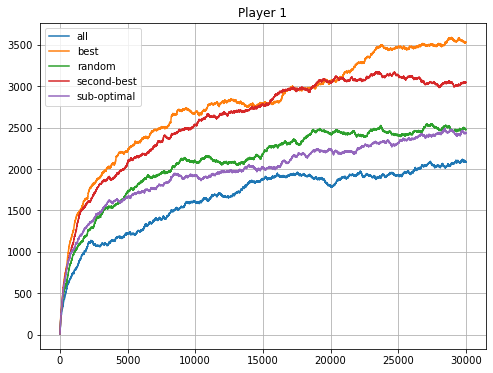

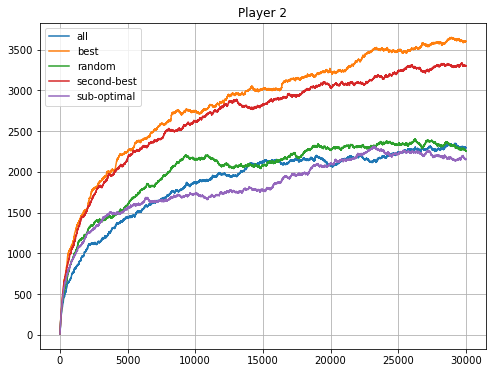

In [185]:
infos = ['all','best', 'random', 'second-best', 'sub-optimal']
plt.figure(figsize = (8,6))
for info in infos:
    file_name = '2_UCBV_Exponential_1_' + info + '.csv'
    file = pd.read_csv(file_name).drop('Unnamed: 0', axis = 1)
    plt.plot(file.loc[:, 'p1_2_regrets'], label = info)
    plt.legend()
plt.grid()
plt.title('Player 1')
plt.show()
plt.figure(figsize = (8,6))
for info in infos:
    file_name = '2_UCBV_Exponential_1_' + info + '.csv'
    file = pd.read_csv(file_name).drop('Unnamed: 0', axis = 1)
    plt.plot(file.loc[:, 'p2_2_regrets'], label = info)
    plt.legend()
plt.grid()
plt.title('Player 2')
plt.show()

In [144]:
n_rounds = 30000
com_freqs = []
exps = []
n = 2
for i in range(1, n_rounds):
    if n**i > n_rounds:
        break
    else:
        exps.append(n**i)
com_freqs.append(exps)

n_arms = 10
single = True
beta = 3
n_variables = 10
n_players = 2
n_iterations = 100
dist = 'Exponential'
player_type = 'ucbv'
lambdas = np.arange(1,11,1)
infos = ['all', 'best', 'random', 'second-best', 'sub-optimal']
for info in infos:
    title = 'UCBV_Exponential_1_Single' + info
    multiple_experiment(n_arms = n_arms, n_variables = n_variables, n_players = n_players, n_rounds = n_rounds, n_iterations = n_iterations, com_freqs = com_freqs, title = title, beta = beta, dist = dist, player_type = player_type, info = info, lambdas = lambdas, single = single)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]<ipython-input-141-6597ddcce525>:10: RuntimeWarning: invalid value encountered in sqrt
  ucb_1 = np.sqrt((2*np.log(current_round)*self.variances[self.n_trials > 0])/self.n_trials[self.n_trials > 0])
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]<ipython-input-141-6597ddcce525>:10: RuntimeWarning: invalid value encountered in sqrt
  ucb_1 = np.sqrt((2*np.log(current_round)*self.variances[self.n_trials > 0])/self.n_trials[self.n_trials > 0])
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]<ipython-input-141-6597ddcce525>:10: RuntimeWarning: invalid value encountered in sqrt
  ucb_1 = np.sqrt((2*np.log(current_round)*self.variances[self.n_trials > 0])/self.n_trials[self.n_trials > 0])
  0%|                                         

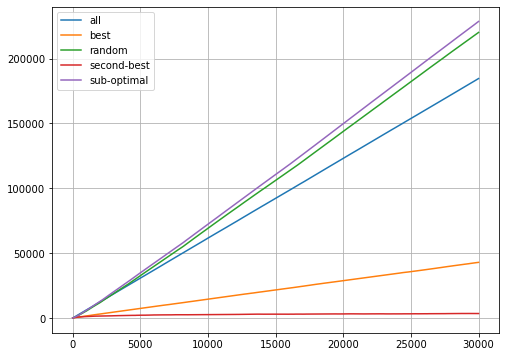

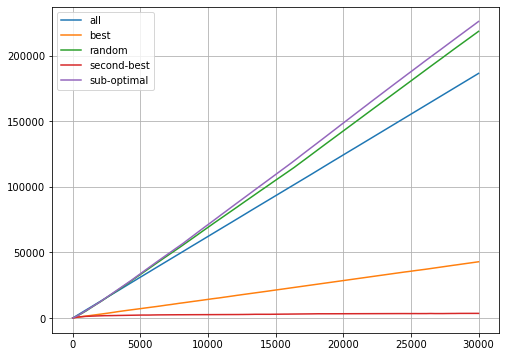

In [145]:
infos = ['all','best', 'random', 'second-best', 'sub-optimal']
plt.figure(figsize = (8,6))
for info in infos:
    file_name = '2_UCBV_Exponential_1_Single' + info + '.csv'
    file = pd.read_csv(file_name).drop('Unnamed: 0', axis = 1)
    plt.plot(file.loc[:, 'p1_2_regrets'], label = info)
    plt.legend()
plt.grid()
plt.show()
plt.figure(figsize = (8,6))
for info in infos:
    file_name = '2_UCBV_Exponential_1_Single' + info + '.csv'
    file = pd.read_csv(file_name).drop('Unnamed: 0', axis = 1)
    plt.plot(file.loc[:, 'p2_2_regrets'], label = info)
    plt.legend()
plt.grid()
plt.show()

In [152]:
n_rounds = 30000
com_freqs = []
exps = []
n = 2
for i in range(1, n_rounds):
    if n**i > n_rounds:
        break
    else:
        exps.append(n**i)
com_freqs.append(exps)

n_arms = 10
beta = 4
n_variables = 10
n_players = 2
n_iterations = 100
lambdas = np.arange(1,11,1)
dist = 'Exponential'
player_type = 'ucbv'
infos = [0,1]
singles = [True, False]
for info in infos:
    for single in singles:
        title = 'UCBV_Exponential_1_Single' + str(info) + '_' + str(single)
        multiple_experiment(n_arms = n_arms, n_variables = n_variables, n_players = n_players, n_rounds = n_rounds, n_iterations = n_iterations, com_freqs = com_freqs, title = title, beta = beta, lambdas = lambdas, dist = dist, player_type = player_type, info = info, single = single)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]<ipython-input-141-6597ddcce525>:10: RuntimeWarning: invalid value encountered in sqrt
  ucb_1 = np.sqrt((2*np.log(current_round)*self.variances[self.n_trials > 0])/self.n_trials[self.n_trials > 0])
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]<ipython-input-141-6597ddcce525>:10: RuntimeWarning: invalid value encountered in sqrt
  ucb_1 = np.sqrt((2*np.log(current_round)*self.variances[self.n_trials > 0])/self.n_trials[self.n_trials > 0])
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]<ipython-input-141-6597ddcce525>:10: RuntimeWarning: invalid value encountered in sqrt
  ucb_1 = np.sqrt((2*np.log(current_round)*self.variances[self.n_trials > 0])/self.n_trials[self.n_trials > 0])
100%|█████████████████████████████████████████

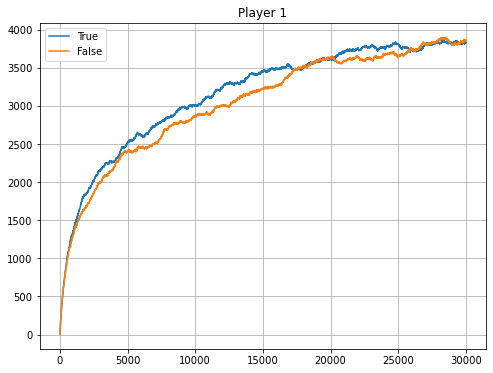

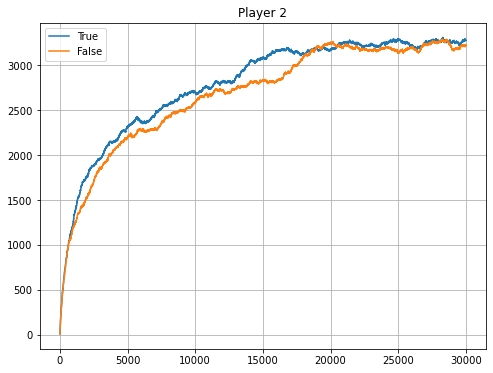

In [191]:
info = 0
singles = [True, False]
plt.figure(figsize = (8,6))
for single in singles:
    file_name = '2_UCBV_Exponential_1_Single' + str(info) + '_' + str(single) + '.csv'
    file = pd.read_csv(file_name).drop('Unnamed: 0', axis = 1)
    plt.plot(file.loc[:, 'p1_2_regrets'], label = single)
    plt.legend()
plt.grid()
plt.title('Player 1')
plt.show()
plt.figure(figsize = (8,6))
for single in singles:
    file_name = '2_UCBV_Exponential_1_Single' + str(info) + '_' + str(single) + '.csv'
    file = pd.read_csv(file_name).drop('Unnamed: 0', axis = 1)
    plt.plot(file.loc[:, 'p2_2_regrets'], label = single)
    plt.legend()
plt.grid()
plt.title('Player 2')
plt.show()

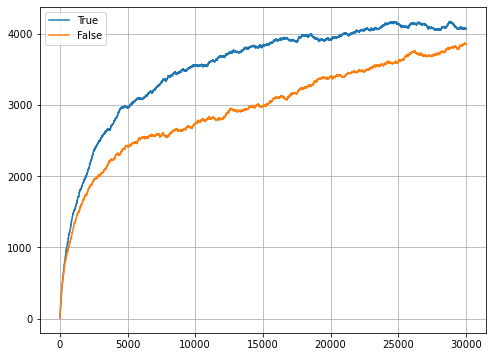

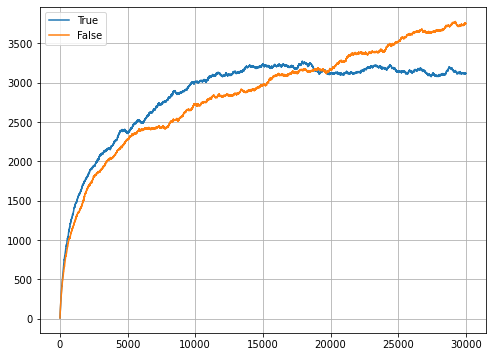

In [167]:
info = 1
singles = [True, False]
plt.figure(figsize = (8,6))
for single in singles:
    file_name = '2_UCBV_Exponential_1_Single' + str(info) + '_' + str(single) + '.csv'
    file = pd.read_csv(file_name).drop('Unnamed: 0', axis = 1)
    plt.plot(file.loc[:, 'p1_2_regrets'], label = single)
    plt.legend()
plt.grid()
plt.show()
plt.figure(figsize = (8,6))
for single in singles:
    file_name = '2_UCBV_Exponential_1_Single' + str(info) + '_' + str(single) + '.csv'
    file = pd.read_csv(file_name).drop('Unnamed: 0', axis = 1)
    plt.plot(file.loc[:, 'p2_2_regrets'], label = single)
    plt.legend()
plt.grid()
plt.show()

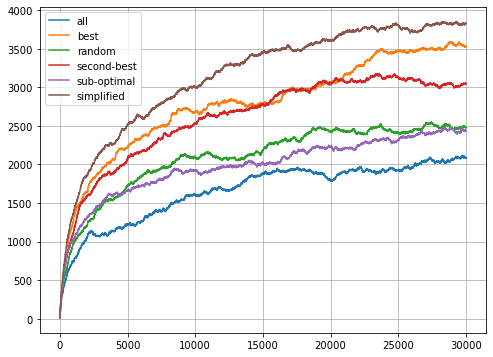

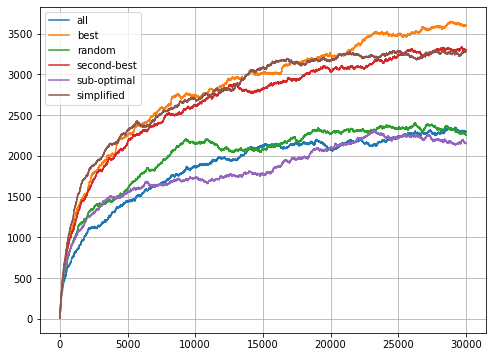

In [181]:
infos = ['all','best', 'random', 'second-best', 'sub-optimal']
init_arm = 0
plt.figure(figsize = (8,6))
for info in infos:
    file_name = '2_UCBV_Exponential_1_' + info + '.csv'
    file = pd.read_csv(file_name).drop('Unnamed: 0', axis = 1)
    plt.plot(file.loc[:, 'p1_2_regrets'], label = info)
    plt.legend()
    
file_name = '2_UCBV_Exponential_1_Single' + str(init_arm) + '_' + str(True) + '.csv'
file = pd.read_csv(file_name).drop('Unnamed: 0', axis = 1)
plt.plot(file.loc[:, 'p1_2_regrets'], label = 'simplified')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize = (8,6))
for info in infos:
    file_name = '2_UCBV_Exponential_1_' + info + '.csv'
    file = pd.read_csv(file_name).drop('Unnamed: 0', axis = 1)
    plt.plot(file.loc[:, 'p2_2_regrets'], label = info)
    plt.legend()
file_name = '2_UCBV_Exponential_1_Single' + str(init_arm) + '_' + str(True) + '.csv'
file = pd.read_csv(file_name).drop('Unnamed: 0', axis = 1)
plt.plot(file.loc[:, 'p2_2_regrets'], label = 'simplified')
plt.legend()
plt.grid()
plt.show()